# Imports

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (Input, Conv2D, AveragePooling2D, Flatten, Dense, Concatenate,
                                     Rescaling, MaxPooling2D, BatchNormalization, Dropout, Add,
                                     Multiply, GlobalAveragePooling2D, Activation, DepthwiseConv2D)
from tensorflow.keras.models import Model
import albumentations as A
from datetime import datetime as dt
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Data Downloading

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d sbaghbidi/human-faces-object-detection
! unzip "/content/human-faces-object-detection.zip" -d "/content/dataset"

100% 497M/498M [00:23<00:00, 26.6MB/s]
100% 498M/498M [00:23<00:00, 22.5MB/s]
Archive:  /content/human-faces-object-detection.zip
  inflating: /content/dataset/faces.csv  
  inflating: /content/dataset/images/00000003.jpg  
  inflating: /content/dataset/images/00000004.jpg  
  inflating: /content/dataset/images/00000005.jpg  
  inflating: /content/dataset/images/00000006.jpg  
  inflating: /content/dataset/images/00000008.jpg  
  inflating: /content/dataset/images/00000011.jpg  
  inflating: /content/dataset/images/00000012.jpg  
  inflating: /content/dataset/images/00000015.jpg  
  inflating: /content/dataset/images/00000018.jpg  
  inflating: /content/dataset/images/00000020.jpg  
  inflating: /content/dataset/images/00000022.jpg  
  inflating: /content/dataset/images/00000023.jpg  
  inflating: /content/dataset/images/00000024.jpg  
  inflating: /content/dataset/images/00000026.jpg  
  inflating: /content/dataset/images/00000031.jpg  
  inflating: /content/dataset/images/00000032.jp

# Data Loading

In [3]:
df = pd.read_csv("/content/dataset/faces.csv")

In [4]:
for index, row in df.iterrows():
  image_path = os.path.join("/content/dataset/images", row['image_name'])
  df.at[index, 'image_path'] = image_path

In [5]:
df.head(5)

,image_name,width,height,x0,y0,x1,y1,image_path
0,00001722.jpg,1333,2000,490,320,687,664,/content/dataset/images/00001722.jpg
1,00001044.jpg,2000,1333,791,119,1200,436,/content/dataset/images/00001044.jpg
2,00001050.jpg,667,1000,304,155,407,331,/content/dataset/images/00001050.jpg
3,00001736.jpg,626,417,147,14,519,303,/content/dataset/images/00001736.jpg
4,00003121.jpg,626,418,462,60,599,166,/content/dataset/images/00003121.jpg


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
 7   image_path  3350 non-null   object
dtypes: int64(6), object(2)
memory usage: 209.5+ KB


In [7]:
images_list = []
bboxes = []

for index, row in df.iterrows():
  image_path = row['image_path']
  images_list.append(image_path)
  x1 = row['x0']
  y1 = row['y0']
  x2 = row['x1']
  y2 = row['y1']
  bbox = [x1, y1, x2, y2]
  bboxes.append(bbox)

print("Number of images in dataset is:", len(images_list))
print("Number of bbox in dataset is:", len(bboxes))

Number of images in dataset is: 3350
Number of bbox in dataset is: 3350


In [8]:
images_data = tf.data.Dataset.from_tensor_slices(images_list)
bbox_data = tf.data.Dataset.from_tensor_slices(bboxes)

dataset = tf.data.Dataset.zip((images_data, bbox_data))

In [9]:
for image, bbox in dataset.take(1):
  print(image)
  print(bbox)

tf.Tensor(b'/content/dataset/images/00001722.jpg', shape=(), dtype=string)
tf.Tensor([490 320 687 664], shape=(4,), dtype=int32)


# Split dataset

In [10]:
def split_dataset(dataset, TRAIN_RATIO, VAL_RATIO):
    dataset_size = len(dataset)
    train_size = int(TRAIN_RATIO * dataset_size)
    val_size = int(VAL_RATIO * dataset_size)

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    val_dataset = test_dataset.skip(val_size)
    test_dataset = test_dataset.take(val_size)

    return train_dataset, test_dataset, val_dataset

In [11]:
train_dataset, test_dataset, val_dataset = split_dataset(dataset, TRAIN_RATIO=0.8, VAL_RATIO=0.1)

In [12]:
print("Number of Training Examples in Training data:", len(train_dataset))
print("Number of Testing Examples in Testing data:", len(test_dataset))
print("Number of validation Examples in validation data:", len(val_dataset))

Number of Training Examples in Training data: 2680
Number of Testing Examples in Testing data: 335
Number of validation Examples in validation data: 335


In [13]:
IMG_SIZE = 256

def get_images_and_bbox(image_path, bbox):
    image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.cast(tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), dtype=tf.float32)
    image = (image - 127.5) / 127.5

    x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
    norm_x1 = float(x1/width)
    norm_y1 = float(y1/height)
    norm_x2 = float(x2/width)
    norm_y2 = float(y2/height)
    norm_bbox = [norm_x1, norm_y1, norm_x2, norm_y2]
    norm_bbox = tf.convert_to_tensor(norm_bbox, tf.float32)

    return image, norm_bbox

In [14]:
train_dataset = train_dataset.map(lambda image, bbox: get_images_and_bbox(image, bbox))
test_dataset = test_dataset.map(lambda image, bbox: get_images_and_bbox(image, bbox))

In [15]:
for image, bbox in train_dataset.take(1):
  print(image.shape)
  print(bbox)

(256, 256, 3)
tf.Tensor([0.3675919  0.16       0.51537883 0.332     ], shape=(4,), dtype=float32)


# Data Visulization

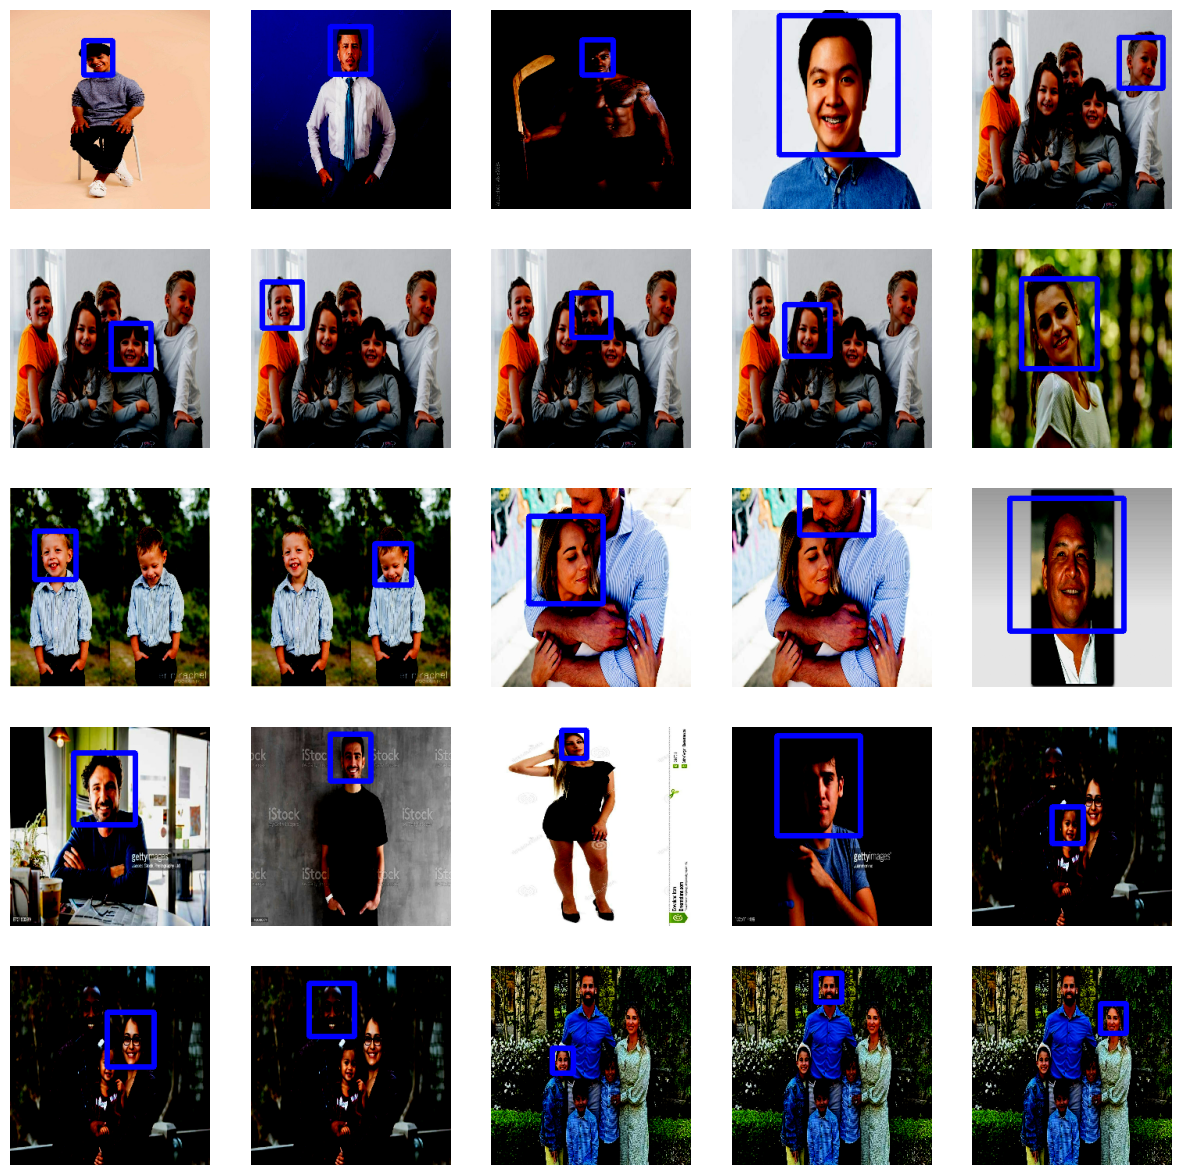

In [16]:
plt.figure(figsize=(15, 15))
for i, (image, bbox) in enumerate(train_dataset.take(25)):
  plt.subplot(5, 5, i+1, xticks=[], yticks=[])
  image = image.numpy()
  x1 = int(bbox[0] * image.shape[1])
  y1 = int(bbox[1] * image.shape[0])
  x2 = int(bbox[2] * image.shape[1])
  y2 = int(bbox[3] * image.shape[0])
  image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 5)
  plt.imshow((image))
  plt.axis('off')

plt.show()

# Data Augumentation

In [17]:
def apply_augmentation(image, bbox):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
    ], bbox_params=A.BboxParams(format='albumentations', label_fields=[]))

    transformed = transform(image=image.numpy(), bboxes=[bbox.numpy()], field_name="bboxes")

    transformed_image = transformed['image']
    transformed_bbox = transformed['bboxes'][0]

    transformed_image = tf.image.resize(transformed_image, size=[IMG_SIZE, IMG_SIZE])
    return transformed_image, transformed_bbox

In [18]:
train_dataset = train_dataset.map(lambda image, bbox: tf.py_function(apply_augmentation, [image, bbox], [tf.float32, tf.float32]))

In [19]:
for image, label in train_dataset.take(1):
  print(image.shape)
  print(label)

(256, 256, 3)
tf.Tensor([0.37801683 0.67980623 0.5430559  0.86891884], shape=(4,), dtype=float32)


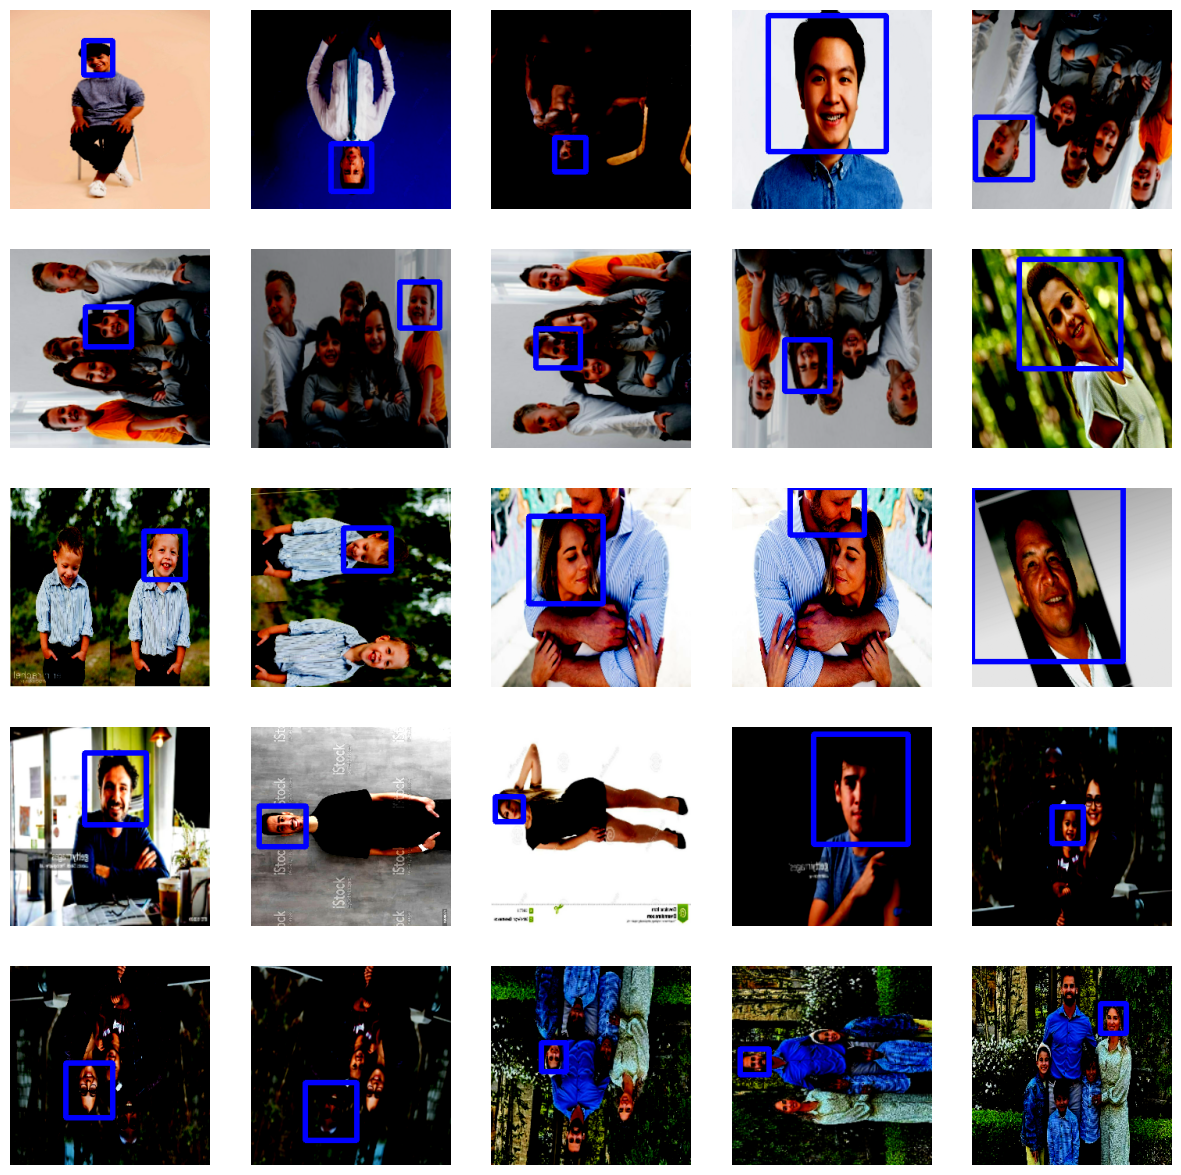

In [20]:
plt.figure(figsize=(15, 15))
for i, (image, bbox) in enumerate(train_dataset.take(25)):
  plt.subplot(5, 5, i+1, xticks=[], yticks=[])
  image = image.numpy()
  x1 = int(bbox[0] * image.shape[1])
  y1 = int(bbox[1] * image.shape[0])
  x2 = int(bbox[2] * image.shape[1])
  y2 = int(bbox[3] * image.shape[0])
  image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 5)
  plt.imshow((image))
  plt.axis('off')

plt.show()

# Data Loading

In [21]:
train_dataset = (
    train_dataset
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
test_dataset = (
    test_dataset
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Model

In [23]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet',
                        input_shape=(256, 256, 3),
                        include_top=False)
base_model.trainable = True

input_layer = Input(shape=(256, 256, 3))
x = base_model(input_layer)
x = Conv2D(256, kernel_size=1, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         327936    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0         
                                                                

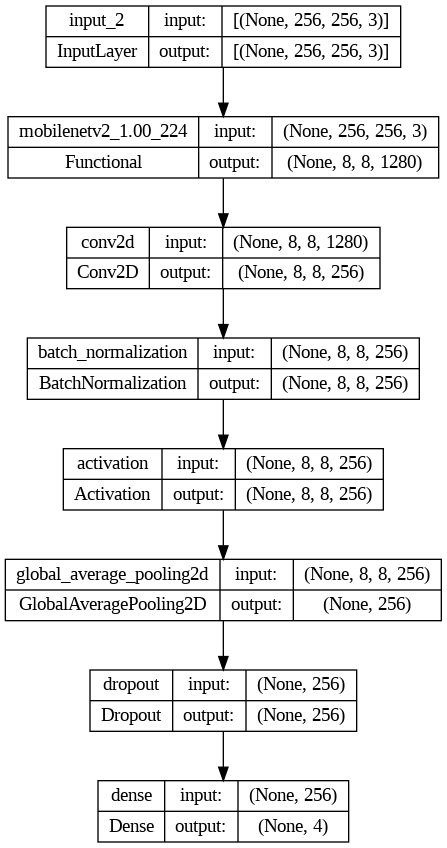

In [24]:
plot_model(model, show_shapes=True)

In [25]:
model.compile(loss="binary_crossentropy",
              optimizer=Adam(1e-4))

In [29]:
def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)

    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

In [35]:
os.mkdir("Generated")

class ShowImage(Callback):
  def on_epoch_end(self, epoch, logs=None):
    plt.figure(figsize=(15, 15))
    for batch_image, batch_bbox in test_dataset.take(1):
        for i in range(25):
            plt.subplot(5, 5, i+1, xticks=[], yticks=[])
            image = batch_image[i].numpy()
            height, width = np.shape(image)[0], np.shape(image)[1]
            pred_bbox = self.model.predict(tf.expand_dims(image, axis=0))[0]
            pred_x1 = int(pred_bbox[0] * width)
            pred_y1 = int(pred_bbox[1] * height)
            pred_x2 = int(pred_bbox[2] * width)
            pred_y2 = int(pred_bbox[3] * height)

            act_x1, act_y1, act_x2, act_y2 = batch_bbox[i]
            act_x1 = int(act_x1 * width)
            act_y1 = int(act_y1 * height)
            act_x2 = int(act_x2 * width)
            act_y2 = int(act_y2 * height)

            act_x1 = int(bbox[0].numpy() * width)
            act_y1 = int(bbox[1].numpy() * height)
            act_x2 = int(bbox[2].numpy() * width)
            act_y2 = int(bbox[3].numpy() * height)

            iou = cal_iou([act_x1, act_y1, act_x2, act_y2], [pred_x1, pred_y1, pred_x2, pred_y2])
            image_np = image.copy()

            image_np = cv2.rectangle(image_np, (act_x1, act_y1), (act_x2, act_y2), (255, 0, 0), 10)  # BLUE
            image_np = cv2.rectangle(image_np, (pred_x1, pred_y1), (pred_x2, pred_y2), (0, 0, 255), 10)  # RED

            x = int(width * 0.05)
            y = int(height * 0.05)
            font_size = int(height * 0.001)
            cv2.putText(image_np, f"IoU: {iou:.4f}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), 3)

            plt.imshow(image_np)
            plt.tight_layout()

    plt.savefig("Generated/gen_images_epoch_{}.png".format(epoch + 1))
    plt.close()

In [36]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=test_dataset,
                    callbacks=[ShowImage()])

1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 55s 55s/step - loss: 0.7895 - val_loss: 0.8057


In [44]:
history.history

{'loss': [0.7894941568374634], 'val_loss': [0.8057494163513184]}

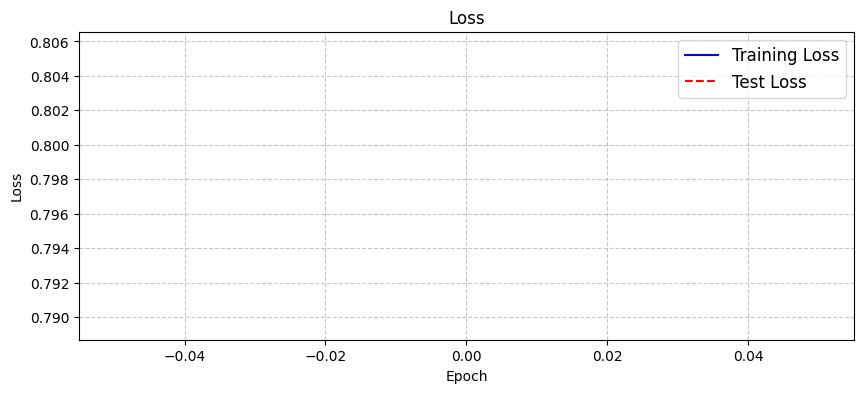

In [45]:
plt.figure(figsize=(10, 4))

plt.plot(history.history['loss'], label='Training Loss', linestyle='-', color='b')
plt.plot(history.history['val_loss'], label='Test Loss', linestyle='--', color='r')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

# Model Evaluation

In [42]:
mean_iou = []

for image_path, bbox in val_dataset:
    image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
    height, width = tf.shape(image)[0].numpy(), tf.shape(image)[1].numpy()
    image_resize = tf.cast(tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), dtype=tf.float32)
    image_pred = (image_resize - 127.5) / 127.5
    pred_bbox = model.predict(tf.expand_dims(image_pred, axis=0))[0]

    pred_x1 = int(pred_bbox[0] * width)
    pred_y1 = int(pred_bbox[1] * height)
    pred_x2 = int(pred_bbox[2] * width)
    pred_y2 = int(pred_bbox[3] * height)

    act_x1, act_y1, act_x2, act_y2 = bbox
    act_x1 = int(act_x1 * width)
    act_y1 = int(act_y1 * height)
    act_x2 = int(act_x2 * width)
    act_y2 = int(act_y2 * height)

    act_x1 = int(bbox[0].numpy() * width)
    act_y1 = int(bbox[1].numpy() * height)
    act_x2 = int(bbox[2].numpy() * width)
    act_y2 = int(bbox[3].numpy() * height)

    iou = cal_iou([act_x1, act_y1, act_x2, act_y2], [pred_x1, pred_y1, pred_x2, pred_y2])
    mean_iou.append(iou)

1/1 [==============================] - 0s 67ms/step
Mean IoU: 0.0000


In [43]:
""" Mean IoU """
score = np.mean(mean_iou, axis=0)
print(f"Mean IoU: {score:.4f}")

Mean IoU: 0.0000


In [ ]:
from PIL import Image
import os

images_folder = "/content/Generated"
gif_filename = "Object_Detection_Images.gif"

images = []
for filename in sorted(os.listdir(images_folder)):
  if filename.endswith(".png"):
    filepath = os.path.join(images_folder, filename)
    img = Image.open(filepath)
    images.append(img)

images[0].save(gif_filename, save_all=True,
              append_images=images[1:],
              duration=500,
              loop=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tf.saved_model.save(model, "/content/drive/MyDrive/Unet_Segementation_model")